In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [3]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
print(data.shape)
# (1338, 7)


(1338, 7)


In [5]:
display(data.isnull().sum())


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


In [7]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Размер тестовой выборки: {X_test.shape[0]}")  # Ответ на вопрос 1

Размер тестовой выборки: 268


In [9]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

intercept = round(model.intercept_, 2)
print(f"Свободный член модели: {intercept}")
def evaluate(model, X, y, name=''):
    y_pred = model.predict(X)
    r2 = round(metrics.r2_score(y, y_pred), 3)
    mae = round(metrics.mean_absolute_error(y, y_pred))
    mape = round(metrics.mean_absolute_percentage_error(y, y_pred) * 100)
    print(f"{name} R2: {r2}, MAE: {mae}, MAPE: {mape}%")
    return y_pred

y_pred_train = evaluate(model, X_train, y_train, "Train")
y_pred_test = evaluate(model, X_test, y_test, "Test")

Свободный член модели: -12390.8
Train R2: 0.742, MAE: 4208, MAPE: 42%
Test R2: 0.784, MAE: 4181, MAPE: 47%


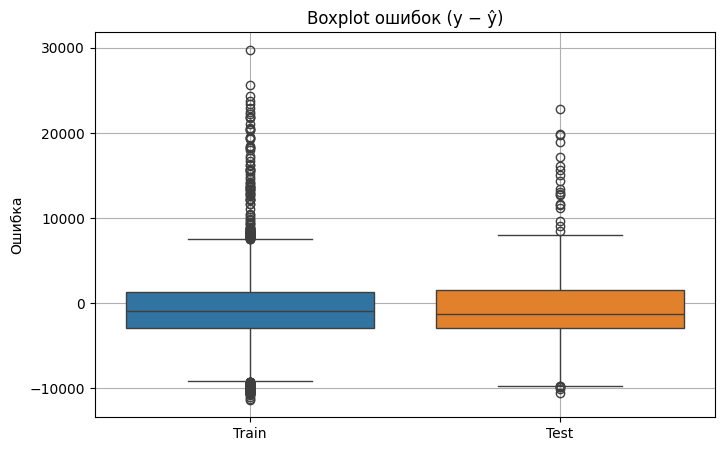

In [12]:
train_errors = y_train - y_pred_train
test_errors = y_test - y_pred_test

error_data = [train_errors.values, test_errors.values]

plt.figure(figsize=(8, 5))
sns.boxplot(data=error_data)
plt.xticks([0, 1], ['Train', 'Test'])
plt.title('Boxplot ошибок (y − ŷ)')
plt.ylabel('Ошибка')
plt.grid(True)
plt.show()

In [14]:
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f'Количество признаков после полиномиального преобразования: {X_train_poly.shape[1]}')

Количество признаков после полиномиального преобразования: 54


In [15]:
poly_model = linear_model.LinearRegression()
poly_model.fit(X_train_poly, y_train)

_ = evaluate(poly_model, X_test_poly, y_test, "Poly Test")

Poly Test R2: 0.867, MAE: 2730, MAPE: 30%


In [18]:
coefficients = poly_model.coef_

print(f'Максимальный коэффициент: {coefficients.max():.2f}')
print(f'Минимальный коэффициент: {coefficients.min():.2f}')

for name, coef in zip(poly.get_feature_names_out(X.columns), coefficients):
   print(f'{name}: {coef:.2f}')

Максимальный коэффициент: 54839.21
Минимальный коэффициент: -9711.00
age: 2849.35
sex: -417.24
bmi: 5935.92
children: 4636.09
smoker: 1139.15
region_northeast: 351.86
region_northwest: -366.49
region_southeast: 227.09
region_southwest: -212.47
age^2: 8399.64
age sex: 812.47
age bmi: 995.69
age children: -1666.91
age smoker: 172.50
age region_northeast: -848.02
age region_northwest: 280.84
age region_southeast: 1455.92
age region_southwest: 1960.61
sex^2: -417.24
sex bmi: 647.47
sex children: -1238.20
sex smoker: 257.34
sex region_northeast: -966.68
sex region_northwest: 311.82
sex region_southeast: 544.21
sex region_southwest: -306.60
bmi^2: -9711.00
bmi children: 1559.87
bmi smoker: 54839.21
bmi region_northeast: 3782.01
bmi region_northwest: 2765.86
bmi region_southeast: -794.73
bmi region_southwest: 182.77
children^2: -2090.62
children smoker: -2233.48
children region_northeast: 2438.06
children region_northwest: 2463.66
children region_southeast: 410.25
children region_southwest: -

In [19]:
lasso = linear_model.Lasso(alpha=1.0, max_iter=2000)
lasso.fit(X_train_poly, y_train)

_ = evaluate(lasso, X_test_poly, y_test, "Lasso Test")

Lasso Test R2: 0.867, MAE: 2719, MAPE: 30%
